# Visual demonstration of trained CNN

### Attempt at Graphic user interface demonstration

In [2]:
import time
import os
import tkinter as tk
from PIL import Image
from PIL import ImageTk
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

Creating Model architecture followed by initializing model w/ saved parameters from last test session

In [3]:
class CNN(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()


            #print toggle
            self.print = printtoggle

            #first convolutional layer
            # in channel, out channel, kernel size, padding
            self.conv1 = nn.Conv2d(1,6,kernel_size=3,padding=1)
            # batch normalization
            self.bnorm1 = nn.BatchNorm2d(6) # input the number of channels on this layer

            #second convolutional layer
            self.conv2 = nn.Conv2d(6,6,kernel_size=3,padding=1,stride=1)
            self.bnorm2 = nn.BatchNorm2d(6)


            #linear decision layers
            """compute the output size for the convolutional layers
                then make it the input size for the linear layers"""
            self.fc1 = nn.Linear(7*7*6,50) 
            self.fc2 = nn.Linear(50,27)
    
        def forward(self, x):
            if self.print: print(f'Input: {list(x.shape)}')

            # first block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv1(x),2)
            x = F.relu(self.bnorm1(x))
            if self.print: print(f'First CPR block: {list(x.shape)}')

            # second block 
            x = F.max_pool2d(self.conv2(x),2)
            x = F.relu(self.bnorm2(x))
            if self.print: print(f'Second CPR block: {list(x.shape)}')

            # reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')

            #linear layers
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            if self.print: print(f'Final output: {list(x.shape)}')

            return x

In [4]:
model = CNN(False)
model.load_state_dict(torch.load('CNN.pth'))
model.eval() # setting it to evaluation mode( parameters behave differently than training)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=27, bias=True)
)

### Working with GUI, 
    Makes popup window for user to draw on
    saves the image from popup window and inverts colors 
    I am inverting the color as the model was trained on the inverted color scheme of the pop up window
    then data pipeline is created so model can properly classifiy image/ letter
    (one difference is images were not normalized and model performance increased in this step)

In [5]:
alphabet_mapping = {
    1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J',
    11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S',
    20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z'
}

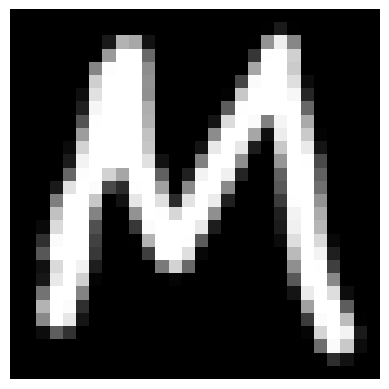

Predicted class: 13
Predicted class: M


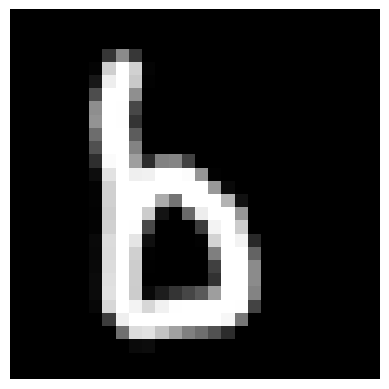

Predicted class: 2
Predicted class: B


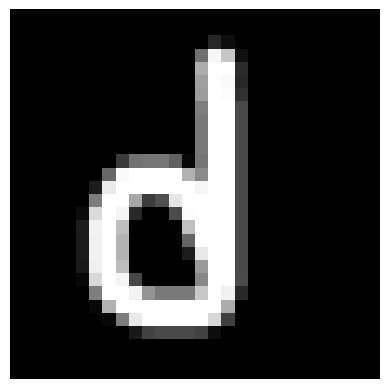

Predicted class: 4
Predicted class: D


In [9]:
def classify_image(model, dataloader):
     # Iterate over the dataloader to get batches of data
    for batch in dataloader:
        # Extract the input tensor from the batch
        input_tensor = batch[0]  # Assuming the input tensor is at index 0
        
        # Perform inference with the model
        with torch.no_grad():
            output = model(input_tensor) # Forward pass
        
        probabilities = F.softmax(output, dim=1)  # Perform post-processing (e.g., softmax) on the output
    
        predicted_class = torch.argmax(probabilities, dim=1)  # Get the predicted class index
        print("Predicted class:", predicted_class.item())
        
        # Optionally, you can return the predicted class or probabilities for further processing
        return predicted_class.item(), probabilities.numpy()

def display_image_from_dataloader(dataloader):
    # Iterate over the dataloader to get a single batch
    for batch in dataloader:
        # Extract the input tensor from the batch
        input_tensor = batch[0]  # Assuming the input tensor is at index 0
        
        # Convert the tensor to a NumPy array and reshape it
        img_array = input_tensor.numpy().squeeze()
        
        # Display the image using Matplotlib
        plt.imshow(img_array, cmap='gray')
        plt.axis('off')
        plt.show()


def clear_canvas():
    canvas.delete("all")

def draw(event):
    x, y = event.x, event.y
    r = 24  # Adjust the size of the brush
    canvas.create_oval(x - r, y - r, x + r, y + r, fill='black')

def save_drawing():
    
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    filename = f"drawn_image_{timestamp}.eps"
    canvas.postscript(file=filename, colormode='color')  # Save the canvas contents as a PostScript file
    img = Image.open(filename) # Open the saved PostScript file using PIL

    img_grayscale = img.convert('L') # for correct number of channels
    img_resized = img_grayscale.resize((28, 28))
    img_array = np.array(img_resized) # Convert the PIL image to a NumPy array
    img_inverted = np.invert(img_array) # invert from white to black
    img_reshaped = img_inverted.reshape((28,28)) # 28 by 28 matrix
    
    img_tensor = torch.from_numpy(img_reshaped)
    img_tensor_float = img_tensor.to(torch.float32)


    # img_tensor_normalized = F.normalize(img_tensor_float, dim = 1) # normalizing tensor values
    img_tensor_batched = img_tensor_float.unsqueeze(0).unsqueeze(0) # Adding correct batch value & channel dimensions
    
    img_array = img_tensor_batched.squeeze().numpy()  # Squeeze to remove batch and channel dimensions

    # Plot the image
    plt.imshow(img_array, cmap='gray')  # Assuming grayscale image
    plt.axis('off')  # Turn off axis
    plt.show()

    dataset = TensorDataset(img_tensor_batched)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # display_image_from_dataloader(dataloader)

    predicted_class, probabilities = classify_image(model, dataloader)
    predicted_letter = alphabet_mapping[predicted_class]        
    print("Predicted class:", predicted_letter)


# Create the main window
root = tk.Tk()
root.title("Handwriting Classification Demo")

# Create a canvas where users can draw
canvas = tk.Canvas(root, width=500, height=500, bg='white', highlightthickness=0)
canvas.pack()

# Bind mouse events to the canvas
canvas.bind("<B1-Motion>", draw)

# Create buttons
clear_button = tk.Button(root, text="Clear", command=clear_canvas)
clear_button.pack(side=tk.LEFT)
save_button = tk.Button(root, text="Save Drawing", command=save_drawing)
save_button.pack(side=tk.LEFT)

# Run the GUI loop
root.mainloop()